**Charline Curaut : 3810013**

# Projet de PIMA : enhancement of vesselness filters in medical application

## generals for both filters

Some useful libraries

In [50]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import skimage.filters

Some useful fonctions

In [64]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def invert(image) :
    return 255 - image

def substract(image1, image2) :
    return image1 - image2

Hessian matrix : 
- application of a Gaussian kernel of standard deviation σ on the image.
- Computation of the directionnal derivate $I_x$ and $I_y$. Using the Sobel kernel.
- Computation of the double directionnal derivate $I_{xx}$, $I_{xy}$, $I_{yy}$.

In [33]:
def Hessian_matrix(image, scale) :
    """ Array[n, m]*float->Array[n*n, m*m]
        return the Hessian matrix from an image
    """
    gauss = gaussianKernel(scale)
    f = scipy.signal.convolve2d(image,gauss,mode='same')
    
    sobelY = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    sobelX = np.transpose(sobelY)
    
    Ix = scipy.signal.convolve2d(f,sobelX,mode='same')
    Iy = scipy.signal.convolve2d(f,sobelY,mode='same')
    
    Ixx = scipy.signal.convolve2d(Ix,sobelX,mode='same')
    Ixy = scipy.signal.convolve2d(Ix,sobelY,mode='same')
    Iyy = scipy.signal.convolve2d(Iy,sobelY,mode='same')
    
    return Ixx, Ixy, Iyy

Computation of eigenvalues from a matrix :

In [34]:
def eigenvalues(image, scale) :
    """ Array[n, m]*float->Array[n,m,2]
        return the eigenvalues of the Hessian matrix of any pixel in an image
    """
    dim = image.shape
    Ixx, Ixy, Iyy = Hessian_matrix(image,scale)
    matrix = np.zeros((dim[0],dim[1],2))
    
    for x in range(dim[0]) :
        for y in range(dim[1]) :
            w, v = np.linalg.eig(np.array([ [Ixx[x,y], Ixy[x,y]],
                                    [Ixy[x,y], Iyy[x,y]] ]))
            matrix[x][y] = w
    
    return matrix

## Frangi & al.

the measures from the eigenvalues of each pixel

In [35]:
def frangi_measures(image, scale) :
    """ Array[n, m]*float->Array[n,m,2]
        return the measures needed for the Frangi filter
    """
    dim = image.shape
    matrix_ev = eignenvalues(image,scale)
    matrix_m = np.zeros(matrix_ev.shape)
    
    for x in range(dim[0]) :
        for y in range(dim[1]) :
            # getting the eigenvalues of the pixel (i,j)
            y1 = matrix_ev[x,y,0]
            y2 = matrix_ev[x,y,1]
            # calculating the measures needed for this pixel
            Rb = y1 / y2
            S = np.sqrt(y1**2 + y2**2)
            # assigning those measures to a matrix
            matrix_m[x,y,0] = Rb
            matrix_m[x,y,1] = S
    
    return matrix_m

In [57]:
def frangi_measures2(image, scale, matrix_ev) :
    """ Array[n, m]*float->Array[n,m,2]
        return the measures needed for the Frangi filter
    """
    dim = image.shape
    matrix_m = np.zeros(matrix_ev.shape)
    
    for x in range(dim[0]) :
        for y in range(dim[1]) :
            # getting the eigenvalues of the pixel (i,j)
            y1 = matrix_ev[x,y,0]
            y2 = matrix_ev[x,y,1]
            # calculating the measures needed for this pixel
            if y2 == 0 :
                Rb = 0
            else : 
                Rb = y1 / y2
            S = np.sqrt(y1**2 + y2**2)
            # assigning those measures to a matrix
            matrix_m[x,y,0] = Rb
            matrix_m[x,y,1] = S
    
    return matrix_m

the calculated fonction for each pixel

In [45]:
def frangi_function(image, scale, gamma=0.5, alpha=0.5, beta=0.5) :
    """ Array[n, m]*float*float*float*float->Array[n,m]
        return the value of the fonction for each pixel
    """
    dim = image.shape
    matrix_ev = eigenvalues(image,scale)
    matrix_m = frangi_measures2(image,scale, matrix_ev)
    matrix_f = np.zeros(dim)
    
    for x in range(dim[0]) :
        for y in range(dim[1]) :
            if matrix_ev[x,y,1] > 0 :
                f = 0
            else :
                e1 = np.exp( (-(matrix_m[x,y,0]**2)) / (2* (beta**2)) )
                e2 = np.exp( (-(matrix_m[x,y,1]**2)) / (2* (gamma**2)) )
                f = e1 * (1-e2)
            matrix_f[x,y] = f
            
    return matrix_f

Calculation of the gamma parameter

In [38]:
def gamma(image) :
    # Hessian norm ?? Norm of matrix 2x2 ??
    pass

## Tests

Loading of images

In [39]:
image108 = np.array(Image.open('images/images/108.jpg'))
annot108 = np.array(Image.open('images/annotations/108.jpg'))

(991, 1000, 3)
(991, 1000)


Text(0.5, 1.0, 'filtre gaussien')

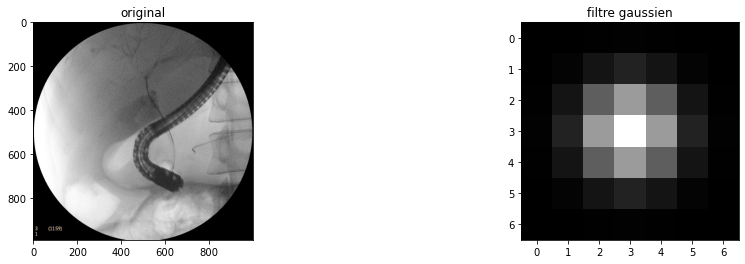

In [40]:
print(image108.shape)
print(image108[:,:,0].shape)
gauss = gaussianKernel(1)

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image108,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(gauss,cmap="gray")
ax.set_title("filtre gaussien, sigma=1")

Text(0.5, 1.0, 'gaussian filter on pixels 2')

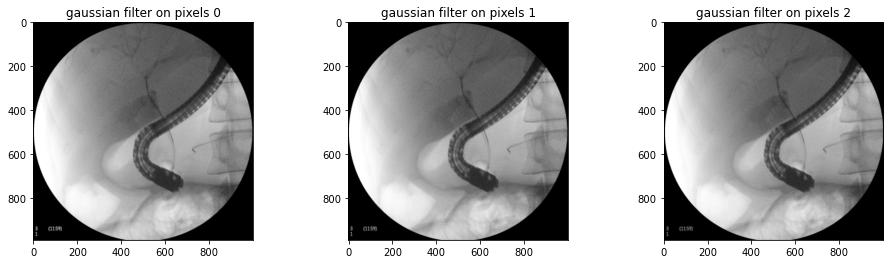

In [41]:
f0 = scipy.signal.convolve2d(image108[:,:,0],gauss,mode='same')
f1 = scipy.signal.convolve2d(image108[:,:,1],gauss,mode='same')
f2 = scipy.signal.convolve2d(image108[:,:,2],gauss,mode='same')

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(f0,cmap="gray")
ax.set_title("gaussian filter on pixels 0")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(f1,cmap="gray")
ax.set_title("gaussian filter on pixels 1")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(f2,cmap="gray")
ax.set_title("gaussian filter on pixels 2")

Text(0.5, 1.0, 'annotation')

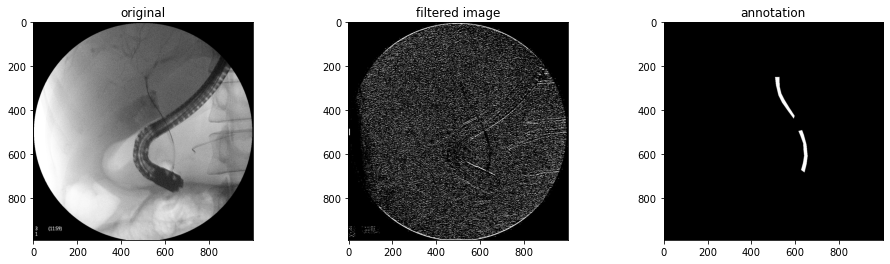

In [62]:
test_img_108 = image108[:,:,0]
filtered_img108 = frangi_function(test_img_108,1,15)

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(test_img_108,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(filtered_img108,cmap="gray")
ax.set_title("filtered image")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(annot108,cmap="gray")
ax.set_title("annotation")

Text(0.5, 1.0, 'filtered image with library')

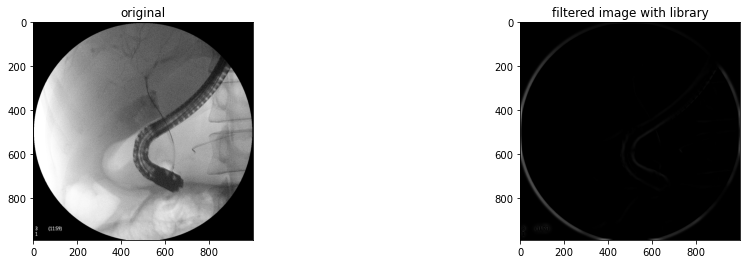

In [55]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 2, 1)
ax.imshow(test_img_108,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(skimage.filters.frangi(test_img_108),cmap="gray")
ax.set_title("filtered image with library")

Text(0.5, 1.0, 'annotation')

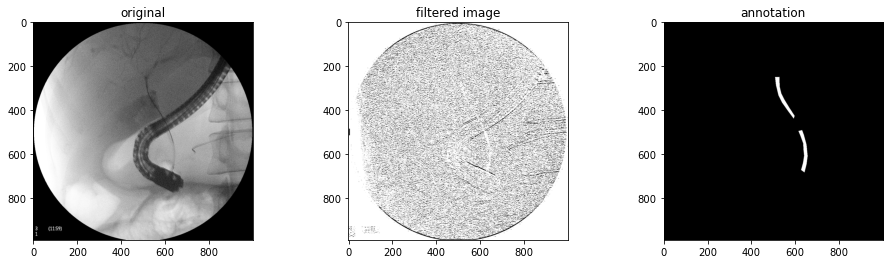

In [63]:
inverted_filtered_img108 = invert(filtered_img108)

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 3, 1)
ax.imshow(test_img_108,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(inverted_filtered_img108,cmap="gray")
ax.set_title("filtered image")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(annot108,cmap="gray")
ax.set_title("annotation")

Text(0.5, 1.0, 'filtered image with library')

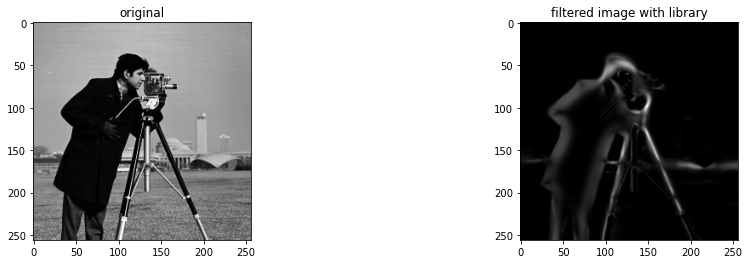

In [73]:
camera = np.array(Image.open('images/cameraman.png'))

fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 2, 1)
ax.imshow(camera,cmap="gray")
ax.set_title("original")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(skimage.filters.frangi(camera),cmap="gray")
ax.set_title("filtered image with library")